<!DOCTYPE html>
<head>
    <meta charset="utf-8">
    <link rel="stylesheet" href="styles.css">
    <link href='https://fonts.googleapis.com/css?family=Merriweather' rel='stylesheet'>
    <div style="background-color: #3D0069; color: white ; font-family: 'Merriweather'; font-weight: bold; text-align: center; padding: 40px; font-size: 16px;">
    <h1>Interrogation of the Parch  & Posey (P & P) Database to Improve Sales Performance</h1>
        by
    
    Buhari Shehu (The Datavestigator)
     

</head>


<img src="erd.png" width=700 height=200 />

<div style="background-color: #F5E8DA; padding: 10px;font-family: 'Merriweather'; font-size: 16px;">
<h2>Table of Contents</h2>
<ol>
<li><a href="#intro">Executive Summary</a></li>    
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Methodology</a></li>
<li><a href="#eda">Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
<li><a href="#model">Recommendations</a></li>
<li><a href="#references">References</a></li>
</ol>
</div>

<link href='https://fonts.googleapis.com/css?family=Merriweather' rel='stylesheet'>
<h2 style="background-color: #F5E8DA; color: #50006C; font-family: 'Merriweather'; font-weight: bold; font-size: 20px; text-align: center; padding: 10px 0;">
  1. Executive Summary
</h2>


<link href='https://fonts.googleapis.com/css?family=Merriweather' rel='stylesheet'>
<h2 style="background-color: #F5E8DA; color: #50006C; font-family: 'Merriweather'; font-weight: bold; font-size: 20px; text-align: center; padding: 10px 0;">
  2. Introduction
</h2>


<link href='https://fonts.googleapis.com/css?family=Merriweather' rel='stylesheet'>
<h2 style="background-color: #F5E8DA; color: #50006C; font-family: 'Merriweather'; font-weight: bold; font-size: 20px; text-align: center; padding: 10px 0;">
  3. Methodology
</h2>


<link href='https://fonts.googleapis.com/css?family=Merriweather' rel='stylesheet'>
<h2 style="background-color: #F5E8DA; color: #50006C; font-family: 'Merriweather'; font-weight: bold; font-size: 20px; text-align: center; padding: 10px 0;">
  4. Analysis
</h2>


### 4.1 Import dependencies and load the database

In [6]:
# Import data analysis toolkits
import pandas as pd
import numpy as np

# Import visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
# Override matplotlib 
sns.set()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Load Magic commands
%load_ext sql

# Load SQLite database
%sql sqlite:////content/drive/MyDrive/DataScience/Projects/SQL/pandp.db

In [7]:
# Load Magic commands
%load_ext sql

# Load SQLite database
%sql sqlite:///pandp.db

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


<div style="border: 5px solid #3D0069;
    border-radius: 10px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 10px; background-color: #F5E8DA">
  <b>Which tables are in the database?</b>
</div>

In [13]:
%%sql
SELECT name tables
FROM sqlite_master 
WHERE type IN ('table','view') AND name NOT LIKE 'sqlite_%' 
ORDER BY 1;

 * sqlite:///pandp.db
Done.


tables
accounts
orders
region
sales_reps
web_events


<div style="border: 5px solid #3D0069;
    border-radius: 10px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 10px; background-color: #F5E8DA">
  <b>When were the earliest and latest orders placed?</b>
</div>

In [15]:
%%sql
SELECT MIN(STRFTIME('%Y %m %d', occurred_at)) 'earliest order date', MAX(STRFTIME('%Y %m %d', occurred_at)) 'latest order date'
FROM orders;

 * sqlite:///pandp.db
Done.


earliest order date,latest order date
2013 12 04,2017 01 02


The earliest recorded order was placed in **`December 4th, 2013`** and the most recent order was placed on **`January 2nd, 2017`**. As a result, these two years will be excluded from some analyses due to the lack of sufficient data.

### Sales representatives

<div style="border: 5px solid #3D0069;
    border-radius: 10px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 10px; background-color: #F5E8DA">
  <b>How many sales representatives do P&P has?</b>
</div>

In [16]:
%%sql
SELECT COUNT(*) 'number of sales persons'
FROM sales_reps;

 * sqlite:///pandp.db
Done.


number of sales persons
50


P&P has 50 sales representatives.

<div style="border: 5px solid #3D0069;
    border-radius: 10px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 10px; background-color: #F5E8DA">
  <b>Who are the top 5 and lowest 5 performing sales representatives?</b>
</div>

In [24]:
%%sql
SELECT s.name sales_rep, ROUND(SUM(o.total_amt_usd), 2) total_sales
FROM sales_reps s
JOIN accounts a
ON s.id = a.sales_rep_id
JOIN orders o
ON a.id = o.account_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 5;

 * sqlite:///pandp.db
Done.


sales_rep,total_sales
Earlie Schleusner,1098137.72
Tia Amato,1010690.6
Vernita Plump,934212.93
Georgianna Chisholm,886244.12
Arica Stoltzfus,810353.34


The top sales representatives are **Earlie Schleusner, Tia Amato, Vernita Plump, Georgianna Chisholm, Arica Stoltzfus**. Each of them recorded more than **$800,000** in sales.

**Low performers**

In [25]:
%%sql
SELECT s.name sales_rep, ROUND(SUM(o.total_amt_usd), 2) total_sales
FROM sales_reps s
JOIN accounts a
ON s.id = a.sales_rep_id
JOIN orders o
ON a.id = o.account_id
GROUP BY 1
ORDER BY 2
LIMIT 5;

 * sqlite:///pandp.db
Done.


sales_rep,total_sales
Nakesha Renn,49361.11
Julie Starr,89097.65
Elba Felder,114976.59
Kathleen Lalonde,116307.79
Akilah Drinkard,136613.99


The low performers are **Nakesha Renn, Julie Starr, Elba Felder, Kathleen Lalonde, Akilah Drinkard** each of them recorded less than **$150,000** in sales. This is more than **500% difference** from the top perfomers.

### What is the performance trends/behaviour of the top performing sales reps??

In [77]:
%%sql
SELECT s.name sales_rep, STRFTIME('%Y', o.occurred_at) year, ROUND(SUM(o.total_amt_usd), 2) total_sales
FROM sales_reps s
JOIN accounts a
ON s.id = a.sales_rep_id
JOIN orders o
ON a.id = o.account_id
WHERE s.name IN ('Earlie Schleusner', 'Tia Amato', 'Vernita Plump', 'Georgianna Chisholm', 'Arica Stoltzfus')
GROUP BY 1, 2
ORDER BY 1;

 * sqlite:///pandp.db
Done.


sales_rep,year,total_sales
Arica Stoltzfus,2013,19596.7
Arica Stoltzfus,2014,178758.0
Arica Stoltzfus,2015,312236.42
Arica Stoltzfus,2016,291377.61
Arica Stoltzfus,2017,8384.61
Earlie Schleusner,2013,33182.64
Earlie Schleusner,2014,253434.98
Earlie Schleusner,2015,241763.05
Earlie Schleusner,2016,560717.22
Earlie Schleusner,2017,9039.83


In [87]:
# Create high sales reps df
high_sales_reps_query = %sql SELECT s.name sales_rep, STRFTIME('%Y', o.occurred_at) year, ROUND(SUM(o.total_amt_usd), 2) total_sales FROM sales_reps s JOIN accounts a ON s.id = a.sales_rep_id JOIN orders o ON a.id = o.account_id WHERE s.name IN ('Earlie Schleusner', 'Tia Amato', 'Vernita Plump', 'Georgianna Chisholm', 'Arica Stoltzfus') GROUP BY 1, 2 ORDER BY 2
high_sales_reps_df = high_sales_reps_query.DataFrame()

 * sqlite:///pandp.db
Done.


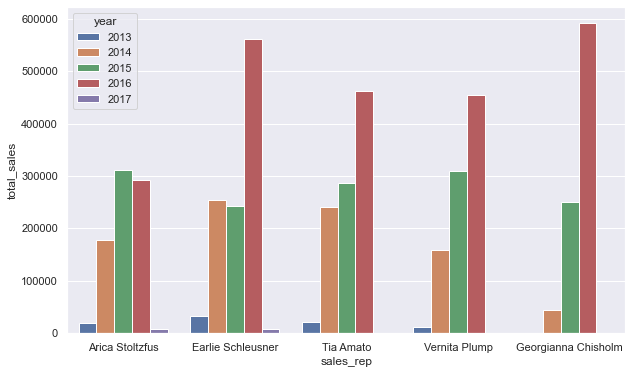

In [89]:
# Create the plot
plt.figure(figsize=(10, 6)) 

# Create the plot
sns.barplot(x='sales_rep', y='total_sales', hue='year', data=high_sales_reps_df)

# Show the plot
plt.show()

The top performers are in close competition/contention with one another and they are improving annually.

### Why Nakesha Renn and co are having low cummulative sales?

In [31]:
%%sql
SELECT s.name sales_rep, STRFTIME('%Y', o.occurred_at) year, ROUND(SUM(o.total_amt_usd), 2) total_sales
FROM sales_reps s
JOIN accounts a
ON s.id = a.sales_rep_id
JOIN orders o
ON a.id = o.account_id
WHERE s.name IN ('Nakesha Renn', 'Julie Starr', 'Elba Felder', 'Kathleen Lalonde', 'Akilah Drinkard')
GROUP BY 1, 2
ORDER BY 1;

 * sqlite:///pandp.db
Done.


sales_rep,year,total_sales
Akilah Drinkard,2014,41117.38
Akilah Drinkard,2015,38109.41
Akilah Drinkard,2016,57387.2
Elba Felder,2013,1228.72
Elba Felder,2014,22893.08
Elba Felder,2015,38088.2
Elba Felder,2016,51730.02
Elba Felder,2017,1036.57
Julie Starr,2013,738.54
Julie Starr,2014,22979.77


In [74]:
# Create low sales reps df
low_sales_reps_query = %sql SELECT s.name sales_rep, STRFTIME('%Y', o.occurred_at) year, ROUND(SUM(o.total_amt_usd), 2) total_sales FROM sales_reps s JOIN accounts a ON s.id = a.sales_rep_id JOIN orders o ON a.id = o.account_id WHERE s.name IN ('Nakesha Renn', 'Julie Starr', 'Elba Felder', 'Kathleen Lalonde', 'Akilah Drinkard') GROUP BY 1, 2 ORDER BY 2 
low_sales_reps_df = low_sales_reps_query.DataFrame()

 * sqlite:///pandp.db
Done.


In [75]:
low_sales_reps_df

,sales_rep,year,total_sales
0,Elba Felder,2013,1228.72
1,Julie Starr,2013,738.54
2,Akilah Drinkard,2014,41117.38
3,Elba Felder,2014,22893.08
4,Julie Starr,2014,22979.77
5,Akilah Drinkard,2015,38109.41
6,Elba Felder,2015,38088.20
7,Akilah Drinkard,2016,57387.20
8,Elba Felder,2016,51730.02
9,Julie Starr,2016,65379.34


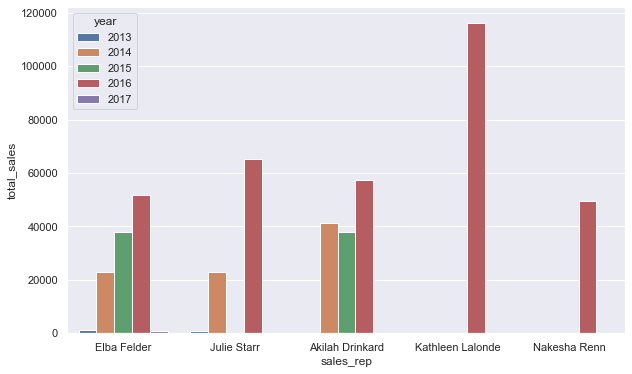

In [76]:
# Create the plot
plt.figure(figsize=(10, 6)) 

# Create the plot
sns.barplot(x='sales_rep', y='total_sales', hue='year', data=low_sales_reps_df)

# Show the plot
plt.show()

- Kathleen and Nakesha only have sales in 2016 which is probably the year they join the company. Thus Kathleen may not be in the low perfomers category. Nakesha may perform better in subsequent years as she gain experience.
- Elba has stunted growth
- Julie has no sale in 2015 

### Customers

<div style="border: 5px solid #3D0069;
    border-radius: 10px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 10px; background-color: #F5E8DA">
  <b>When were the earliest and latest orders placed?</b>
</div>

**How many customers?**

In [93]:
%%sql
SELECT COUNT(*) number_of_customers
FROM accounts;

 * sqlite:///pandp.db
Done.


number_of_customers
351


**Top 5 and lowest 5 cutomers**

In [98]:
%%sql
SELECT a.name, ROUND(SUM(o.total_amt_usd), 2) total_purchase
FROM accounts a
JOIN orders o
ON a.id = o.account_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 5;

 * sqlite:///pandp.db
Done.


name,total_purchase
EOG Resources,382873.3
Mosaic,345618.59
IBM,326819.48
General Dynamics,300694.79
Republic Services,293861.14


In [101]:
%%sql
WITH cte AS (SELECT a.name, ROUND(SUM(o.total_amt_usd), 2) total_purchase
FROM accounts a
JOIN orders o
ON a.id = o.account_id
GROUP BY 1
ORDER BY 2
LIMIT 5)

SELECT *
FROM cte
ORDER BY 2 DESC;

 * sqlite:///pandp.db
Done.


name,total_purchase
Bed Bath & Beyond,1069.64
Deere,1036.57
Level 3 Communications,881.73
Delta Air Lines,859.64
Nike,390.25


**Habits of top and lowest customers**

**New Customers**

In [109]:
%%sql
SELECT  STRFTIME('%Y', occurred_at) year,  COUNT(DISTINCT account_id) number_of_customers
FROM orders
GROUP BY 1;

 * sqlite:///pandp.db
Done.


year,number_of_customers
2013,61
2014,80
2015,134
2016,317
2017,14


In [139]:


%%sql
WITH cte AS (SELECT DISTINCT account_id FROM orders WHERE STRFTIME('%Y', occurred_at) != '2013')

SELECT DISTINCT account_id 
FROM orders o
JOIN cte
ON o.account_id = cte.account_id
WHERE STRFTIME('%Y', o.occurred_at) = '2013' AND (account_id NOT IN cte.account_id)

 * sqlite:///pandp.db
(sqlite3.OperationalError) no such table: cte.account_id
[SQL: WITH cte AS (SELECT DISTINCT account_id FROM orders WHERE STRFTIME('%Y', occurred_at) != '2013')

SELECT DISTINCT account_id 
FROM orders o
JOIN cte
ON o.account_id = cte.account_id
WHERE STRFTIME('%Y', o.occurred_at) = '2013' AND (account_id NOT IN cte.account_id)]
(Background on this error at: https://sqlalche.me/e/14/e3q8)


In [141]:
%%sql

WITH cte AS (
    SELECT DISTINCT account_id FROM orders WHERE STRFTIME('%Y', occurred_at) != '2013'
)
SELECT *
FROM cte
JOIN orders o
ON cte.account_id = o.account_id
WHERE STRFTIME('%Y', o.occurred_at) = '2013' AND (account_id NOT IN cte.account_id);


 * sqlite:///pandp.db
(sqlite3.OperationalError) no such table: cte.account_id
[SQL: WITH cte AS (
    SELECT DISTINCT account_id FROM orders WHERE STRFTIME('%Y', occurred_at) != '2013'
)
SELECT *
FROM cte
JOIN orders o
ON cte.account_id = o.account_id
WHERE STRFTIME('%Y', o.occurred_at) = '2013' AND (account_id NOT IN cte.account_id);]
(Background on this error at: https://sqlalche.me/e/14/e3q8)


In [119]:
%%sql
SELECT COUNT(DISTINCT account_id)
FROM orders 
WHERE STRFTIME('%Y', occurred_at) != '2013'

 * sqlite:///pandp.db
Done.


COUNT(DISTINCT account_id)
349


**Segementation**

In [164]:
%%sql
SELECT account_id, ROUND(SUM(total_amt_usd), 2) total_purchase
FROM orders
GROUP BY 1

 * sqlite:///pandp.db
Done.


account_id,total_purchase
1001,124014.87
1011,2734.59
1021,20767.15
1031,7474.32
1041,15184.46
1051,21937.08
1061,23667.51
1071,9995.05
1081,154811.43
1091,51647.76


In [165]:
segement_qry = %sql SELECT account_id, ROUND(SUM(total_amt_usd), 2) total_purchase FROM orders GROUP BY 1
segment_df = segement_qry.DataFrame()

 * sqlite:///pandp.db
Done.


In [166]:
segment_df.describe(percentiles=[0.2, 0.4, 0.6, 0.8, 0.9])

,account_id,total_purchase
count,350.000000,350.000000
mean,2753.914286,66118.605229
std,1014.672626,71299.263574
min,1001.000000,390.250000
20%,1699.000000,11450.198000
40%,2407.000000,27364.832000
50%,2756.000000,38337.055000
60%,3105.000000,54832.256000
80%,3803.000000,118938.526000
90%,4152.000000,156676.340000


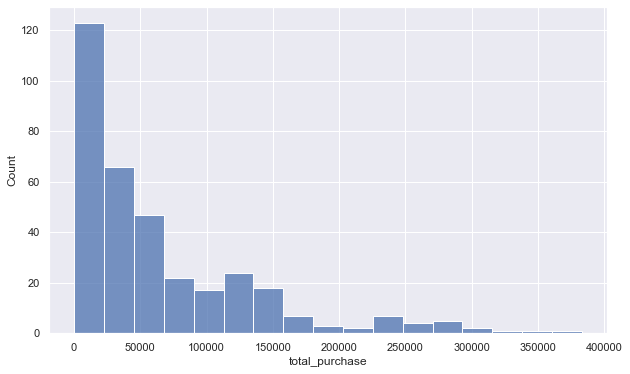

In [168]:
# Create the plot
plt.figure(figsize=(10, 6)) 

# Create the plot
sns.histplot(data=segment_df, x='total_purchase')

# Set the x-axis scale to log
#plt.gca().set(xscale='log')

# Show the plot
plt.show()

In [178]:
%%sql
WITH cte1 AS (
    SELECT account_id, 
           ROUND(SUM(total_amt_usd), 2) total_purchase
    FROM orders
    GROUP BY 1
),
cte2 AS (
    SELECT account_id, 
           total_purchase,
           CASE 
               WHEN total_purchase > 150000 THEN 'Platinum'
               WHEN total_purchase > 100000 AND total_purchase <= 150000 THEN 'Gold'
               WHEN total_purchase > 50000 AND total_purchase <= 100000 THEN 'Silver'
               ELSE 'Bronze' END AS segment
    FROM cte1
)
SELECT segment, COUNT(segment) count
FROM cte2
GROUP BY 1;


 * sqlite:///pandp.db
Done.


segment,count
Bronze,203
Gold,43
Platinum,39
Silver,65


**Has any Platinum customer churn?**

### Channels

Most profitable channel

In [179]:
%%sql
SELECT w.channel, ROUND(SUM(o.total_amt_usd/1e6), 2) total_sales_million_usd
FROM orders o
JOIN accounts a
ON o.account_id = a.id
JOIN web_events w
ON w.account_id = a.id

GROUP BY 1
ORDER BY 2 DESC;

 * sqlite:///pandp.db
Done.


channel,total_sales_million_usd
direct,639.7
facebook,103.03
organic,102.05
adwords,97.78
twitter,50.67
banner,48.08


In [180]:
# create revenue by channel
channel = %sql SELECT w.channel, ROUND(SUM(o.total_amt_usd/1e6), 2) total_sales_million_usd FROM orders o JOIN accounts a ON o.account_id = a.id JOIN web_events w ON w.account_id = a.id WHERE o.occurred_at GROUP BY 1 ORDER BY 2 DESC;
channel_df = channel.DataFrame()

 * sqlite:///pandp.db
Done.


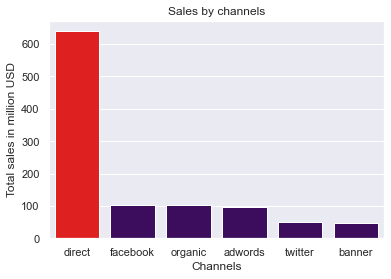

In [182]:
# Create a bar plot with the 'channel' column on the x-axis and the 'total_sales_million_usd' column on the y-axis
# Define colour palette
colour = '#3D0069'
colours = [colour for i in range(len(channel_df)-1)]
palette = ['red']
palette.extend(colours)

ax = sns.barplot(x='channel', y='total_sales_million_usd', data=channel_df, palette=palette)

# Set the x-axis label to 'Channels'
ax.set_xlabel('Channels')

# Set the y-axis label to 'Total sales in million USD'
ax.set_ylabel('Total sales in million USD')

# Set the title to 'Revenue by channel'
ax.set_title('Sales by channels');


**Regions**

In [187]:
%%sql
SELECT r.name, ROUND(SUM(o.total_amt_usd), 2) total_purchase
FROM region r
JOIN sales_reps s
ON r.id = s.region_id
JOIN accounts a
ON s.id = a.sales_rep_id
JOIN orders o
ON a.id = o.account_id
GROUP BY 1
ORDER BY 2 DESC

 * sqlite:///pandp.db
Done.


name,total_purchase
Northeast,7744405.36
Southeast,6458497.0
West,5925122.96
Midwest,3013486.51


**Graph**

### Products

In [189]:
%%sql
SELECT *
FROM orders
LIMIT 5

 * sqlite:///pandp.db
Done.


id,account_id,occurred_at,standard_qty,gloss_qty,poster_qty,total,standard_amt_usd,gloss_amt_usd,poster_amt_usd,total_amt_usd
1,1001,2015-10-06 17:31:14,123,22,24,169,613.77,164.78,194.88,973.43
2,1001,2015-11-05 03:34:33,190,41,57,288,948.1,307.09,462.84,1718.03
3,1001,2015-12-04 04:21:55,85,47,0,132,424.15,352.03,0,776.18
4,1001,2016-01-02 01:18:24,144,32,0,176,718.56,239.68,0,958.24
5,1001,2016-02-01 19:27:27,108,29,28,165,538.92,217.21,227.36,983.49


In [191]:
%%sql
SELECT ROUND(SUM(standard_amt_usd), 2) total_standard_usd, 
ROUND(SUM(gloss_amt_usd), 2) total_gloss_usd, 
ROUND(SUM(poster_amt_usd), 2) total_poster_usd
FROM orders

 * sqlite:///pandp.db
Done.


total_standard_usd,total_gloss_usd,total_poster_usd
9672346.54,7593159.77,5876005.52


Max and min

In [192]:
%%sql
SELECT MAX(standard_qty) max_standard_qty, 
        MAX(gloss_qty) max_gloss_qty,
        MAX(poster_qty) max_poster_qty
FROM orders

 * sqlite:///pandp.db
Done.


max_standard_qty,max_gloss_qty,max_poster_qty
22591,14281,28262


In [193]:
%%sql
SELECT MIN(standard_qty) min_standard_qty, 
        MIN(gloss_qty) min_gloss_qty,
        MIN(poster_qty) min_poster_qty
FROM orders

 * sqlite:///pandp.db
Done.


min_standard_qty,min_gloss_qty,min_poster_qty
0,0,0


In [195]:
%%sql
SELECT ROUND(AVG(standard_qty)) avg_standard_qty, 
        ROUND(AVG(gloss_qty)) avg_gloss_qty,
        ROUND(AVG(poster_qty)) avg_poster_qty
FROM orders

 * sqlite:///pandp.db
Done.


avg_standard_qty,avg_gloss_qty,avg_poster_qty
280.0,147.0,105.0


In [206]:
%%sql
WITH cte AS (SELECT STRFTIME('%m', occurred_at) month, 
        SUM(standard_qty) total_standard_qty,
        SUM(gloss_qty) total_gloss_qty,
        SUM(poster_qty) total_poster_qty
FROM orders
WHERE occurred_at BETWEEN '2016-01-01' AND '2017-01-01'
GROUP BY 1)

SELECT ROUND(AVG(total_standard_qty)) avg_standard_qty,
        ROUND(AVG(total_gloss_qty)) avg_gloss_qty,
        ROUND(AVG(total_poster_qty)) avg_poster_qty
FROM cte

 * sqlite:///pandp.db
Done.


avg_standard_qty,avg_gloss_qty,avg_poster_qty
89563.0,46151.0,34420.0


In [205]:
%%sql
WITH cte AS (SELECT STRFTIME('%m', occurred_at) month, 
        SUM(standard_qty) total_standard_qty,
        SUM(gloss_qty) total_gloss_qty,
        SUM(poster_qty) total_poster_qty
FROM orders
WHERE occurred_at BETWEEN '2016-01-01' AND '2017-01-01'
GROUP BY 1)

SELECT MAX(total_standard_qty) max_standard_qty,
        MAX(total_gloss_qty) max_gloss_qty,
        MAX(total_poster_qty) max_poster_qty
FROM cte

 * sqlite:///pandp.db
Done.


max_standard_qty,max_gloss_qty,max_poster_qty
123997,67667,79398


In [207]:
%%sql
WITH cte AS (SELECT STRFTIME('%m', occurred_at) month, 
        SUM(standard_qty) total_standard_qty,
        SUM(gloss_qty) total_gloss_qty,
        SUM(poster_qty) total_poster_qty
FROM orders
WHERE occurred_at BETWEEN '2016-01-01' AND '2017-01-01'
GROUP BY 1)

SELECT MIN(total_standard_qty) min_standard_qty,
        MIN(total_gloss_qty) min_gloss_qty,
        MIN(total_poster_qty) min_poster_qty
FROM cte

 * sqlite:///pandp.db
Done.


min_standard_qty,min_gloss_qty,min_poster_qty
56022,27765,16358


In [209]:
%%sql
SELECT STRFTIME('%m', occurred_at) month, 
        SUM(standard_qty) total_standard_qty,
        SUM(gloss_qty) total_gloss_qty,
        SUM(poster_qty) total_poster_qty
FROM orders
WHERE occurred_at BETWEEN '2016-01-01' AND '2017-01-01'
GROUP BY 1

 * sqlite:///pandp.db
Done.


month,total_standard_qty,total_gloss_qty,total_poster_qty
01,56022,27765,17002
02,56758,28459,16358
03,68378,35194,23924
04,71762,32856,19853
05,70841,36936,24248
06,102390,56704,26714
07,87616,47835,53229
08,97114,49422,28682
09,103977,52442,36301
10,121065,54406,45119


**Histogram**

- Top product of all time
- Trends for three years
- MAX orders for all
- MIN orders 
- Average orders
- Distribution of orders

**GROWTH**

- Running totals
- That comparison chart
- Annual growth rates comparison

The preschool's enrollment numbers for the past four years are:

350 in 2016
390 in 2017
402 in 2018
489 in 2019
You can use the average growth rate over time calculation method to find the average annual growth rate for the preschool. In this example, the present value is 489, the past value is 328 and the number of years is 4:

Growth rate after 2016: (390 - 350) / 350 x 100 = 11.43%
Growth rate after 2017: (402 - 390) / 390 x 100 = 3.08%
Growth rate after 2018: (489 - 402) / 402 x 100 = 21.64%
Average growth rate over time = (11.43% + 3.08% + 21.64%) / 3 = 12.05% per year

In [ ]:
100*(current - lag)/lag

In [241]:
%%sql
WITH cte AS (SELECT STRFTIME('%Y', occurred_at) year, ROUND(SUM(total_amt_usd),2) annual_amt_usd
FROM orders
GROUP BY 1
ORDER BY 1)

SELECT  year, 
        annual_amt_usd, 
        LAG(annual_amt_usd) OVER (ORDER BY year) AS lag,
        ROUND(100*(annual_amt_usd - LAG(annual_amt_usd) OVER (ORDER BY year))/LAG(annual_amt_usd) OVER (ORDER BY year), 2) AS growth_rate
FROM cte
WHERE year NOT IN ('2013', '2017')

 * sqlite:///pandp.db
Done.


year,annual_amt_usd,lag,growth_rate
2014,4069106.54,None,None
2015,5752004.94,4069106.54,41.36
2016,12864917.92,5752004.94,123.66


<div style="border: 5px solid #6f00ff;
    border-radius: 20px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 16px 0; background-color: #F5E8DA">
  <b>Comparing 2016 to 2015, how did sales fare?</b>
</div>

In [247]:
%%sql
SELECT strftime('%Y %m', occurred_at) years, strftime('%m', occurred_at) months, ROUND(SUM(total_amt_usd), 2) total_sales
FROM orders
WHERE occurred_at LIKE '2015%' OR occurred_at LIKE '2016%'
GROUP BY 1

 * sqlite:///pandp.db
Done.


years,months,total_sales
2015 01,01,347804.3
2015 02,02,333688.01
2015 03,03,519403.4
2015 04,04,451753.57
2015 05,05,390830.84
2015 06,06,420906.13
2015 07,07,461895.49
2015 08,08,463754.33
2015 09,09,510848.57
2015 10,10,554190.81


In [248]:
total_sales_qry = %sql SELECT strftime('%Y %m', occurred_at) years, strftime('%m', occurred_at) months, ROUND(SUM(total_amt_usd), 2) average_sales FROM orders WHERE occurred_at LIKE '2015%' OR occurred_at LIKE '2016%' GROUP BY 1
total_sales_df = total_sales_qry.DataFrame()

 * sqlite:///pandp.db
Done.


In [250]:
total_sales_df

,years,months,average_sales
0,2015 01,01,347804.30
1,2015 02,02,333688.01
2,2015 03,03,519403.40
3,2015 04,04,451753.57
4,2015 05,05,390830.84
5,2015 06,06,420906.13
6,2015 07,07,461895.49
7,2015 08,08,463754.33
8,2015 09,09,510848.57
9,2015 10,10,554190.81


<AxesSubplot:xlabel='months', ylabel='month_over_month_change'>

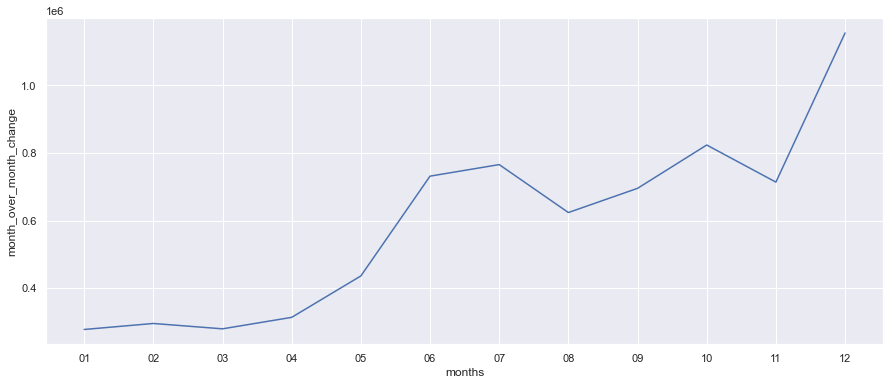

In [253]:
total_sales_df['month_over_month_change'] = total_sales_df['average_sales'] - total_sales_df['average_sales'].shift(12)
# Set the figure size to 10 inches wide and 6 inches tall

plt.figure(figsize=(15, 6))
# Create a line plot with the year on the x-axis and the YoY change on the y-axis
sns.lineplot(x='months', y='month_over_month_change', data=total_sales_df)

- high variability
- overall 2015 was better
- seems no seasonality in the dataset
- high volatility = high variability?

In [ ]:
%%sql
SELECT
FROM

Sales persons
- How many
- Top 5 and Lowest 5?

Cutomers
- Count
- Top 5 and lowest 5
- Habits of top and low
- New customers
- Attrition
- Customer segmentation based on their purchase: CASE, Know the distribution of the , Plot their distribution after segmenting 




Channels
- Distribution 
- Trend
- Regions
- Top regions

Products
- Top product of all time
- Trends for three years
- MAX orders for all
- MIN orders 
- Average orders
- Distribution of orders 




Growth
- Ytd
- Running totals
- That comparison chart
- Lead, lag?.
- Annual growth rates comparison
- Trends YOY
Compare monthly and annual number of sales




<div style="border: 5px solid #3D0069;
    border-radius: 10px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 10px; background-color: #F5E8DA">
  <b>When were the earliest and latest orders placed?</b>
</div>

In [15]:
%%sql
SELECT MIN(STRFTIME('%Y %m %d', occurred_at)) 'earliest order date', MAX(STRFTIME('%Y %m %d', occurred_at)) 'latest order date'
FROM orders;

 * sqlite:///pandp.db
Done.


earliest order date,latest order date
2013 12 04,2017 01 02


The earliest recorded order was placed in December 2013 and the most recent order was placed on January 2nd, 2017. As a result, these two years will be excluded from some analyses due to the lack of sufficient data.

<div style="border: 5px solid #3D0069;
    border-radius: 10px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 10px; background-color: #F5E8DA">
  <b>When were the earliest and latest orders placed?</b>
</div>

In [15]:
%%sql
SELECT MIN(STRFTIME('%Y %m %d', occurred_at)) 'earliest order date', MAX(STRFTIME('%Y %m %d', occurred_at)) 'latest order date'
FROM orders;

 * sqlite:///pandp.db
Done.


earliest order date,latest order date
2013 12 04,2017 01 02


The earliest recorded order was placed in December 2013 and the most recent order was placed on January 2nd, 2017. As a result, these two years will be excluded from some analyses due to the lack of sufficient data.

<div style="border: 5px solid #3D0069;
    border-radius: 10px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 10px; background-color: #F5E8DA">
  <b>When were the earliest and latest orders placed?</b>
</div>

In [15]:
%%sql
SELECT MIN(STRFTIME('%Y %m %d', occurred_at)) 'earliest order date', MAX(STRFTIME('%Y %m %d', occurred_at)) 'latest order date'
FROM orders;

 * sqlite:///pandp.db
Done.


earliest order date,latest order date
2013 12 04,2017 01 02


The earliest recorded order was placed in December 2013 and the most recent order was placed on January 2nd, 2017. As a result, these two years will be excluded from some analyses due to the lack of sufficient data.

<div style="border: 5px solid #3D0069;
    border-radius: 10px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 10px; background-color: #F5E8DA">
  <b>When were the earliest and latest orders placed?</b>
</div>

In [15]:
%%sql
SELECT MIN(STRFTIME('%Y %m %d', occurred_at)) 'earliest order date', MAX(STRFTIME('%Y %m %d', occurred_at)) 'latest order date'
FROM orders;

 * sqlite:///pandp.db
Done.


earliest order date,latest order date
2013 12 04,2017 01 02


The earliest recorded order was placed in December 2013 and the most recent order was placed on January 2nd, 2017. As a result, these two years will be excluded from some analyses due to the lack of sufficient data.

<div style="border: 5px solid #3D0069;
    border-radius: 10px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 10px; background-color: #F5E8DA">
  <b>When were the earliest and latest orders placed?</b>
</div>

In [15]:
%%sql
SELECT MIN(STRFTIME('%Y %m %d', occurred_at)) 'earliest order date', MAX(STRFTIME('%Y %m %d', occurred_at)) 'latest order date'
FROM orders;

 * sqlite:///pandp.db
Done.


earliest order date,latest order date
2013 12 04,2017 01 02


The earliest recorded order was placed in December 2013 and the most recent order was placed on January 2nd, 2017. As a result, these two years will be excluded from some analyses due to the lack of sufficient data.

<div style="border: 5px solid #3D0069;
    border-radius: 10px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 10px; background-color: #F5E8DA">
  <b>When were the earliest and latest orders placed?</b>
</div>

In [15]:
%%sql
SELECT MIN(STRFTIME('%Y %m %d', occurred_at)) 'earliest order date', MAX(STRFTIME('%Y %m %d', occurred_at)) 'latest order date'
FROM orders;

 * sqlite:///pandp.db
Done.


earliest order date,latest order date
2013 12 04,2017 01 02


The earliest recorded order was placed in December 2013 and the most recent order was placed on January 2nd, 2017. As a result, these two years will be excluded from some analyses due to the lack of sufficient data.

<div style="border: 5px solid #3D0069;
    border-radius: 10px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 10px; background-color: #F5E8DA">
  <b>When were the earliest and latest orders placed?</b>
</div>

In [15]:
%%sql
SELECT MIN(STRFTIME('%Y %m %d', occurred_at)) 'earliest order date', MAX(STRFTIME('%Y %m %d', occurred_at)) 'latest order date'
FROM orders;

 * sqlite:///pandp.db
Done.


earliest order date,latest order date
2013 12 04,2017 01 02


The earliest recorded order was placed in December 2013 and the most recent order was placed on January 2nd, 2017. As a result, these two years will be excluded from some analyses due to the lack of sufficient data.

<div style="border: 5px solid #3D0069;
    border-radius: 10px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 10px; background-color: #F5E8DA">
  <b>When were the earliest and latest orders placed?</b>
</div>

In [15]:
%%sql
SELECT MIN(STRFTIME('%Y %m %d', occurred_at)) 'earliest order date', MAX(STRFTIME('%Y %m %d', occurred_at)) 'latest order date'
FROM orders;

 * sqlite:///pandp.db
Done.


earliest order date,latest order date
2013 12 04,2017 01 02


The earliest recorded order was placed in December 2013 and the most recent order was placed on January 2nd, 2017. As a result, these two years will be excluded from some analyses due to the lack of sufficient data.

<div style="border: 5px solid #3D0069;
    border-radius: 10px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 10px; background-color: #F5E8DA">
  <b>When were the earliest and latest orders placed?</b>
</div>

In [15]:
%%sql
SELECT MIN(STRFTIME('%Y %m %d', occurred_at)) 'earliest order date', MAX(STRFTIME('%Y %m %d', occurred_at)) 'latest order date'
FROM orders;

 * sqlite:///pandp.db
Done.


earliest order date,latest order date
2013 12 04,2017 01 02


The earliest recorded order was placed in December 2013 and the most recent order was placed on January 2nd, 2017. As a result, these two years will be excluded from some analyses due to the lack of sufficient data.

<div style="border: 5px solid #3D0069;
    border-radius: 10px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 10px; background-color: #F5E8DA">
  <b>When were the earliest and latest orders placed?</b>
</div>

In [15]:
%%sql
SELECT MIN(STRFTIME('%Y %m %d', occurred_at)) 'earliest order date', MAX(STRFTIME('%Y %m %d', occurred_at)) 'latest order date'
FROM orders;

 * sqlite:///pandp.db
Done.


earliest order date,latest order date
2013 12 04,2017 01 02


The earliest recorded order was placed in December 2013 and the most recent order was placed on January 2nd, 2017. As a result, these two years will be excluded from some analyses due to the lack of sufficient data.

<div style="border: 5px solid #3D0069;
    border-radius: 10px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 10px; background-color: #F5E8DA">
  <b>When were the earliest and latest orders placed?</b>
</div>

In [15]:
%%sql
SELECT MIN(STRFTIME('%Y %m %d', occurred_at)) 'earliest order date', MAX(STRFTIME('%Y %m %d', occurred_at)) 'latest order date'
FROM orders;

 * sqlite:///pandp.db
Done.


earliest order date,latest order date
2013 12 04,2017 01 02


The earliest recorded order was placed in December 2013 and the most recent order was placed on January 2nd, 2017. As a result, these two years will be excluded from some analyses due to the lack of sufficient data.

<div style="border: 5px solid #3D0069;
    border-radius: 10px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 10px; background-color: #F5E8DA">
  <b>When were the earliest and latest orders placed?</b>
</div>

In [15]:
%%sql
SELECT MIN(STRFTIME('%Y %m %d', occurred_at)) 'earliest order date', MAX(STRFTIME('%Y %m %d', occurred_at)) 'latest order date'
FROM orders;

 * sqlite:///pandp.db
Done.


earliest order date,latest order date
2013 12 04,2017 01 02


The earliest recorded order was placed in December 2013 and the most recent order was placed on January 2nd, 2017. As a result, these two years will be excluded from some analyses due to the lack of sufficient data.

<div style="border: 5px solid #3D0069;
    border-radius: 10px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 10px; background-color: #F5E8DA">
  <b>When were the earliest and latest orders placed?</b>
</div>

In [15]:
%%sql
SELECT MIN(STRFTIME('%Y %m %d', occurred_at)) 'earliest order date', MAX(STRFTIME('%Y %m %d', occurred_at)) 'latest order date'
FROM orders;

 * sqlite:///pandp.db
Done.


earliest order date,latest order date
2013 12 04,2017 01 02


The earliest recorded order was placed in December 2013 and the most recent order was placed on January 2nd, 2017. As a result, these two years will be excluded from some analyses due to the lack of sufficient data.

<div style="border: 5px solid #3D0069;
    border-radius: 10px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 10px; background-color: #F5E8DA">
  <b>When were the earliest and latest orders placed?</b>
</div>

In [15]:
%%sql
SELECT MIN(STRFTIME('%Y %m %d', occurred_at)) 'earliest order date', MAX(STRFTIME('%Y %m %d', occurred_at)) 'latest order date'
FROM orders;

 * sqlite:///pandp.db
Done.


earliest order date,latest order date
2013 12 04,2017 01 02


The earliest recorded order was placed in December 2013 and the most recent order was placed on January 2nd, 2017. As a result, these two years will be excluded from some analyses due to the lack of sufficient data.

<div style="border: 5px solid #3D0069;
    border-radius: 10px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 10px; background-color: #F5E8DA">
  <b>When were the earliest and latest orders placed?</b>
</div>

In [15]:
%%sql
SELECT MIN(STRFTIME('%Y %m %d', occurred_at)) 'earliest order date', MAX(STRFTIME('%Y %m %d', occurred_at)) 'latest order date'
FROM orders;

 * sqlite:///pandp.db
Done.


earliest order date,latest order date
2013 12 04,2017 01 02


The earliest recorded order was placed in December 2013 and the most recent order was placed on January 2nd, 2017. As a result, these two years will be excluded from some analyses due to the lack of sufficient data.

The earliest recorded order was placed in December 2013 and the most recent order was placed on January 2nd, 2017. As a result, these two years will be excluded from some analyses due to the lack of sufficient data.

The earliest recorded order was placed in December 2013 and the most recent order was placed on January 2nd, 2017. As a result, these two years will be excluded from some analyses due to the lack of sufficient data.

<div style="font-size: 18px; font-family: 'Merriweather'">
  When were the earliest and latest orders placed?
</div>

In [9]:
%%sql
SELECT t1.id, t1.name, t1.channel, MAX(count) max_chan
FROM (SELECT a.id, a.name, w.channel, COUNT(*) count
FROM accounts a
JOIN web_events w
ON a.id = w.account_id
GROUP BY 1, 2, 3) t1
GROUP BY 1, 2

 * sqlite:///pandp.db
Done.


id,name,channel,max_chan
1001,Walmart,direct,22
1011,Exxon Mobil,adwords,1
1021,Apple,direct,9
1031,Berkshire Hathaway,direct,1
1041,McKesson,direct,5
1051,UnitedHealth Group,direct,9
1061,CVS Health,direct,4
1071,General Motors,direct,1
1081,Ford Motor,direct,29
1091,AT&T,direct,35


In [ ]:
%%sql
SELECT id,
        account_id,
        standard_qty,
        STRFTIME('%Y %m', occurred_at) month,
        DENSE_RANK() OVER (PARTITION BY account_id ORDER BY STRFTIME('%Y %m', occurred_at)) AS dense_rank,
        SUM(standard_qty) OVER (PARTITION BY account_id ORDER BY STRFTIME('%Y %m', occurred_at)) AS running_sum_std_qty,
        COUNT(standard_qty) OVER (PARTITION BY account_id ORDER BY STRFTIME('%Y %m', occurred_at)) AS count__std_qty,
        AVG(standard_qty) OVER (PARTITION BY account_id ORDER BY STRFTIME('%Y %m', occurred_at)) AS avg__std_qty,
        MIN(standard_qty) OVER (PARTITION BY account_id ORDER BY STRFTIME('%Y %m', occurred_at)) AS min__std_qty,
        MAX(standard_qty) OVER (PARTITION BY account_id ORDER BY STRFTIME('%Y %m', occurred_at)) AS max__std_qty
FROM orders

In [ ]:
%%sql
WITH cte AS (SELECT account_id,
        SUM(standard_qty) AS sum_std_qty
        FROM orders
        GROUP BY 1)
SELECT  account_id,
        sum_std_qty,
        LAG(sum_std_qty) OVER (ORDER BY sum_std_qty) AS lag,
        LEAD(sum_std_qty) OVER (ORDER BY sum_std_qty) AS lead,
        sum_std_qty - LAG(sum_std_qty) OVER (ORDER BY sum_std_qty) AS lag_diffrence,
        LEAD(sum_std_qty) OVER (ORDER BY sum_std_qty) - sum_std_qty AS lead_diffrence
FROM cte


In [ ]:
%%sql
SELECT id, account_id, standard_qty, SUM(standard_qty) OVER (ORDER BY id) AS total
FROM orders;

In [ ]:
%%sql
SELECT t3.id, t3.name, t3.channel, t3.count
FROM (SELECT a.id, a.name, w.channel, COUNT(*) count
FROM accounts a
JOIN web_events w
ON a.id = w.account_id
GROUP BY 1, 2, 3) t3


JOIN (SELECT t1.id, t1.name, MAX(count) max_chan
FROM (SELECT a.id, a.name, w.channel, COUNT(*) count
FROM accounts a
JOIN web_events w
ON a.id = w.account_id
GROUP BY 1, 2, 3) t1
GROUP BY 1, 2
ORDER BY 1) t2
ON t2.id = t3.id AND t2.max_chan = t3.count
ORDER BY 1, 4


In [ ]:
%%sql
SELECT standard_qty,
       SUM(total) OVER(ORDER BY occurred_at) AS running_total
FROM orders

In [156]:
%%sql
SELECT strftime('%Y %m', occurred_at) months, ROUND(AVG(total_amt_usd), 2) average_sales
FROM orders
WHERE occurred_at LIKE '2015%'
GROUP BY 1

 * sqlite:///pandp.db
Done.


months,average_sales
2015 01,2922.73
2015 02,3239.69
2015 03,4026.38
2015 04,3672.79
2015 05,2916.65
2015 06,3314.22
2015 07,3163.67
2015 08,3198.31
2015 09,3648.92
2015 10,3166.8


In [72]:
%%sql
SELECT w.channel, ROUND(SUM(o.total_amt_usd), 2) total_sales
FROM orders o
JOIN accounts a
ON o.account_id = a.id
JOIN web_events w
ON w.account_id = a.id
WHERE o.occurred_at BETWEEN '2015-01-01' AND '2016-01-01'
GROUP BY 1
ORDER BY 2 DESC;

 * sqlite:///pandp.db
Done.


channel,total_sales
direct,201196130.62
facebook,31954065.03
organic,31918987.73
adwords,30321237.21
twitter,16374278.84
banner,14248005.61


## 2. Connecting to a serverless SQL database

We can connect to a SQLite database as follows: 

1. We need to install some dependencies. This includes the following Python modules: 

 - Running ***locally***: Once-off installations
      - `pip install sqlalchemy`
      - `pip install ipython-sql`
      - `pip install pymysql`

 - Running on ***Google Colab***: 
      - no dependencies required

<div style="border: 5px solid #6f00ff;
    border-radius: 20px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 16px 0; background-color: #D9EEE1">
  <b>Which tables are in the database?</b>
</div>

In [16]:
%%sql
SELECT * 
FROM orders
LIMIT 5;

 * sqlite:///pandp.db
Done.


id,account_id,occurred_at,standard_qty,gloss_qty,poster_qty,total,standard_amt_usd,gloss_amt_usd,poster_amt_usd,total_amt_usd
1,1001,2015-10-06 17:31:14,123,22,24,169,613.77,164.78,194.88,973.43
2,1001,2015-11-05 03:34:33,190,41,57,288,948.1,307.09,462.84,1718.03
3,1001,2015-12-04 04:21:55,85,47,0,132,424.15,352.03,0,776.18
4,1001,2016-01-02 01:18:24,144,32,0,176,718.56,239.68,0,958.24
5,1001,2016-02-01 19:27:27,108,29,28,165,538.92,217.21,227.36,983.49


<div style="border: 5px solid #3D0069;
    border-radius: 10px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 10px; background-color: #F5E8DA">
  <b>What are the five latest orders?</b>
</div>

In [15]:
%%sql
SELECT *
FROM orders
ORDER BY occurred_at DESC
LIMIT 5;

 * sqlite:///pandp.db
Done.


id,account_id,occurred_at,standard_qty,gloss_qty,poster_qty,total,standard_amt_usd,gloss_amt_usd,poster_amt_usd,total_amt_usd
6451,3841,2017-01-02 00:02:40,42,506,302,850,209.58,3789.94,2452.24,6451.76
3546,3841,2017-01-01 23:50:16,291,36,26,353,1452.09,269.64,211.12,1932.85
6454,3861,2017-01-01 22:29:50,38,167,51,256,189.62,1250.83,414.12,1854.57
3554,3861,2017-01-01 22:17:26,497,0,23,520,2480.03,0,186.76,2666.79
6556,4051,2017-01-01 21:04:25,0,65,50,115,0,486.85,406,892.85


<div style="border: 5px solid #6f00ff;
    border-radius: 20px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 16px 0; background-color: #F5E8DA">
  <b>In which accounts did the top five purchases of all time occur?<b>
</div>

In [18]:
%%sql
SELECT account_id, total_amt_usd
FROM orders
ORDER BY total_amt_usd DESC
LIMIT 5;

 * sqlite:///pandp.db
Done.


account_id,total_amt_usd
4251,232207.07
4161,112875.18
4211,107533.55
2861,95005.82
4101,93547.84


<div style="border: 5px solid #6f00ff;
    border-radius: 20px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 16px 0; background-color: #F5E8DA">
  <b>In which accounts did the lowest five purchases of all time occur?<b>
</div>

In [19]:
%%sql
SELECT account_id, total_amt_usd
FROM orders
ORDER BY total_amt_usd
LIMIT 5;

 * sqlite:///pandp.db
Done.


account_id,total_amt_usd
1131,0
1951,0
2881,0
1221,0
1231,0


<div style="border: 5px solid #6f00ff;
    border-radius: 20px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 16px 0; background-color: #F5E8DA">
  <b>Which records have total purchase greater than $100,000 ?<b>
</div>

In [25]:
%%sql
SELECT *
FROM orders
WHERE total_amt_usd > 100000;

 * sqlite:///pandp.db
Done.


id,account_id,occurred_at,standard_qty,gloss_qty,poster_qty,total,standard_amt_usd,gloss_amt_usd,poster_amt_usd,total_amt_usd
3892,4161,2016-06-24 13:32:55,22591,13,6,22610,112729.09,97.37,48.72,112875.18
3963,4211,2015-03-30 00:05:30,114,14281,0,14395,568.86,106964.69,0,107533.55
4016,4251,2016-12-26 08:53:24,521,16,28262,28799,2599.79,119.84,229487.44,232207.07


In [ ]:
#Which channel which sales rep in what region names of companies that these sales were made?
%%sql
SELECT w.channel
FROM orders
JOIN web_events w
WHERE total_amt_usd > 100000;

<div style="border: 5px solid #6f00ff;
    border-radius: 20px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 16px 0; background-color: #F5E8DA">
  <b>What are the account names and the sales representative for the top three accounts above?</b>
</div>

In [57]:
%%sql
SELECT a.name account_name, s.name sales_rep,  o.total_amt_usd
FROM orders o
JOIN accounts a
ON o.account_id = a.id
JOIN sales_reps s
ON a.sales_rep_id = s.id
WHERE total_amt_usd > 100000
ORDER BY 3 DESC;

 * sqlite:///pandp.db
Done.


account_name,sales_rep,total_amt_usd
Pacific Life,Dawna Agnew,232207.07
Core-Mark Holding,Maryanna Fiorentino,112875.18
EOG Resources,Arica Stoltzfus,107533.55


<div style="border: 5px solid #6f00ff;
    border-radius: 20px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 16px 0; background-color: #F5E8DA">
  <b>What are the names, websites and primary points of contact of the top three accounts above?<b>
</div>

In [31]:
%%sql
SELECT name, website, primary_poc
FROM accounts
WHERE id in (4161, 4211, 4251);

 * sqlite:///pandp.db
Done.


name,website,primary_poc
Core-Mark Holding,www.core-mark.com,Marita Demasi
EOG Resources,www.eogresources.com,Alida Desrosier
Pacific Life,www.pacificlife.com,Kyoko Randall


<div style="border: 5px solid #6f00ff;
    border-radius: 20px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 16px 0; background-color: #F5E8DA">
  <b>What is the unit price of a standard paper?</b>
</div>

In [36]:
%%sql
SELECT standard_amt_usd/standard_qty standard_paper_unit_price_usd
FROM orders
LIMIT 1;

 * sqlite:///pandp.db
Done.


standard_paper_unit_price_usd
4.99


<div style="border: 5px solid #6f00ff;
    border-radius: 20px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 16px 0; background-color: #F5E8DA">
  <b>Which orders contain only standard paper with a quantity greater than 1000?<b>
</div>

In [37]:
%%sql
SELECT *
FROM orders
WHERE standard_qty > 1000 AND poster_qty = 0 AND gloss_qty = 0;

 * sqlite:///pandp.db
Done.


id,account_id,occurred_at,standard_qty,gloss_qty,poster_qty,total,standard_amt_usd,gloss_amt_usd,poster_amt_usd,total_amt_usd
2613,2951,2016-08-15 00:06:12,1171,0,0,1171,5843.29,0,0,5843.29
3260,3491,2014-08-29 22:43:00,1552,0,0,1552,7744.48,0,0,7744.48


<div style="border: 5px solid #6f00ff;
    border-radius: 20px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 16px 0; background-color: #F5E8DA">
  <b>Which orders were placed between 2014-12-29 and 2014-12-30?</b>
</div>

In [44]:
%%sql
SELECT *
FROM orders
WHERE occurred_at BETWEEN '2014-12-29' AND '2014-12-31';

 * sqlite:///pandp.db
Done.


id,account_id,occurred_at,standard_qty,gloss_qty,poster_qty,total,standard_amt_usd,gloss_amt_usd,poster_amt_usd,total_amt_usd
256,1251,2014-12-30 02:30:01,336,52,12,400,1676.64,389.48,97.44,2163.56
604,1451,2014-12-29 07:50:25,412,0,0,412,2055.88,0,0,2055.88
3084,3411,2014-12-29 06:34:35,286,12,22,320,1427.14,89.88,178.64,1695.66
3960,4211,2014-12-29 22:37:31,96,19,16,131,479.04,142.31,129.92,751.27
4163,4341,2014-12-29 04:40:43,584,36,12,632,2914.16,269.64,97.44,3281.24
4465,1251,2014-12-30 02:10:42,510,574,202,1286,2544.9,4299.26,1640.24,8484.4
4697,1451,2014-12-29 07:40:17,54,542,271,867,269.46,4059.58,2200.52,6529.56
6168,3411,2014-12-29 06:27:25,43,615,301,959,214.57,4606.35,2444.12,7265.04
6688,4211,2014-12-29 22:41:19,513,568,190,1271,2559.87,4254.32,1542.8,8356.99


In [46]:
%%sql
SELECT orders.*,
accounts.*
FROM orders
JOIN accounts
ON orders.account_id = accounts.id
LIMIT 5;

 * sqlite:///pandp.db
Done.


id,account_id,occurred_at,standard_qty,gloss_qty,poster_qty,total,standard_amt_usd,gloss_amt_usd,poster_amt_usd,total_amt_usd,id_1,name,website,lat,long,primary_poc,sales_rep_id
1,1001,2015-10-06 17:31:14,123,22,24,169,613.77,164.78,194.88,973.43,1001,Walmart,www.walmart.com,40.23849561,-75.10329704,Tamara Tuma,321500
2,1001,2015-11-05 03:34:33,190,41,57,288,948.1,307.09,462.84,1718.03,1001,Walmart,www.walmart.com,40.23849561,-75.10329704,Tamara Tuma,321500
3,1001,2015-12-04 04:21:55,85,47,0,132,424.15,352.03,0,776.18,1001,Walmart,www.walmart.com,40.23849561,-75.10329704,Tamara Tuma,321500
4,1001,2016-01-02 01:18:24,144,32,0,176,718.56,239.68,0,958.24,1001,Walmart,www.walmart.com,40.23849561,-75.10329704,Tamara Tuma,321500
5,1001,2016-02-01 19:27:27,108,29,28,165,538.92,217.21,227.36,983.49,1001,Walmart,www.walmart.com,40.23849561,-75.10329704,Tamara Tuma,321500


<div style="border: 5px solid #6f00ff;
    border-radius: 20px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 16px 0; background-color: #F5E8DA">
  <b>How much sales were generated by each channel in 2015?</b>
</div>

In [94]:
%%sql
SELECT w.channel, ROUND(SUM(o.total_amt_usd/1e6), 2) total_sales_million_usd
FROM orders o
JOIN accounts a
ON o.account_id = a.id
JOIN web_events w
ON w.account_id = a.id
WHERE o.occurred_at BETWEEN '2015-01-01' AND '2016-01-01'
GROUP BY 1
ORDER BY 2 DESC;

 * sqlite:///pandp.db
Done.


channel,total_sales_million_usd
direct,201.2
facebook,31.95
organic,31.92
adwords,30.32
twitter,16.37
banner,14.25


In [133]:
# create revenue by channel
channel = %sql SELECT w.channel, ROUND(SUM(o.total_amt_usd/1e6), 2) total_sales_million_usd FROM orders o JOIN accounts a ON o.account_id = a.id JOIN web_events w ON w.account_id = a.id WHERE o.occurred_at BETWEEN '2015-01-01' AND '2016-01-01' GROUP BY 1 ORDER BY 2 DESC;
channel_df = channel.DataFrame()

 * sqlite:///pandp.db
Done.


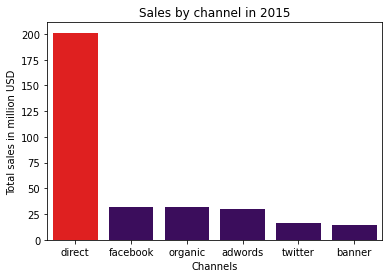

In [138]:
# Create a bar plot with the 'channel' column on the x-axis and the 'total_sales_million_usd' column on the y-axis
# Define colour palette
colour = '#3D0069'
colours = [colour for i in range(len(channel_df)-1)]
palette = ['red']
palette.extend(colours)

ax = sns.barplot(x='channel', y='total_sales_million_usd', data=channel_df, palette=palette)

# Set the x-axis label to 'Channels'
ax.set_xlabel('Channels')

# Set the y-axis label to 'Total sales in million USD'
ax.set_ylabel('Total sales in million USD')

# Set the title to 'Revenue by channel in 2015'
ax.set_title('Sales by channel in 2015');


<div style="border: 5px solid #6f00ff;
    border-radius: 20px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 16px 0; background-color: #F5E8DA">
  <b>What are the 10 latest orders?<b>
</div>

Which channel send the most traffic per day on average to parch and posey
Solution: we need to aggregate events by channel by day then we average them

In [212]:
%%sql
SELECT channel,
       AVG(event_count) AS avg_event_count
FROM 
(SELECT strftime('%Y %m %d', occurred_at) day, 
        channel, 
        COUNT(*) event_count
FROM web_events
GROUP BY 1, 2) sub
GROUP BY 1
ORDER BY 2 DESC

 * sqlite:///pandp.db
Done.


channel,avg_event_count
direct,4.896487985212569
organic,1.6672504378283712
facebook,1.5983471074380164
adwords,1.5701906412478337
twitter,1.3166666666666667
banner,1.2899728997289972


 return only orders that occurred in the same month as PandP first order ever

In [233]:
%%sql
SELECT *
FROM orders
WHERE STRFTIME('%Y %m', occurred_at) LIKE (SELECT STRFTIME('%Y %m', MIN(occurred_at)) earliest_month FROM orders)

 * sqlite:///pandp.db
Done.


id,account_id,occurred_at,standard_qty,gloss_qty,poster_qty,total,standard_amt_usd,gloss_amt_usd,poster_amt_usd,total_amt_usd
147,1181,2013-12-17 23:02:57,339,0,0,339,1691.61,0,0,1691.61
243,1251,2013-12-11 20:36:06,86,39,34,159,429.14,292.11,276.08,997.33
287,1281,2013-12-05 20:33:56,492,73,0,565,2455.08,546.77,0,3001.85
346,1301,2013-12-08 07:05:07,85,89,32,206,424.15,666.61,259.84,1350.6
446,1401,2013-12-12 16:33:14,299,39,28,366,1492.01,292.11,227.36,2011.48
484,1411,2013-12-30 21:42:43,498,41,0,539,2485.02,307.09,0,2792.11
561,1441,2013-12-28 12:54:50,317,30,5,352,1581.83,224.7,40.6,1847.13
702,1521,2013-12-31 00:36:59,266,0,26,292,1327.34,0,211.12,1538.46
739,1531,2013-12-10 14:43:18,501,0,0,501,2499.99,0,0,2499.99
795,1561,2013-12-17 21:54:36,380,109,0,489,1896.2,816.41,0,2712.61


In [ ]:
%%sql
SELECT *
FROM 
ORDER BY 
LIMIT 5

In [ ]:
%%sql
SELECT *
FROM 
ORDER BY 
LIMIT 5

In [ ]:
%%sql
SELECT *
FROM 
ORDER BY 
LIMIT 5

In [ ]:
Which channels 
SELECT *
FROM web_events
WHERE channel IN ('organic', 'adwords') AND occurred_at BETWEEN '2016-01-01' AND '2017-01-01'
ORDER BY occurred_at DESC;

<div style="border: 5px solid #6f00ff;
    border-radius: 20px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 16px 0; background-color: #F5E8DA">
  <b>What are the 10 latest orders?<b>
</div>

<div style="border: 5px solid #6f00ff;
    border-radius: 20px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 16px 0; background-color: #F5E8DA">
  <b>What are the 10 latest orders?<b>
</div>

<div style="border: 5px solid #6f00ff;
    border-radius: 20px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 16px 0; background-color: #F5E8DA">
  <b>What are the 10 latest orders?<b>
</div>

<div style="border: 5px solid #6f00ff;
    border-radius: 20px; text-align: center; font-size: 20px; font-family: 'Merriweather'; padding: 16px 0; background-color: #F5E8DA">
  <b>What are the 10 latest orders?<b>
</div>


<div style="border: 10px solid #6f00ff;
    border-radius: 20px; text-align: center; padding: 20px 0; background-color: #F5E8DA">
  This is a curved edge border box with the color #6f00ff.
</div>


<link href='https://fonts.googleapis.com/css?family=Merriweather' rel='stylesheet'>
<h2 style="background-color: #F5E8DA; color: #50006C; font-family: 'Merriweather'; font-weight: bold; font-size: 20px; text-align: center; padding: 10px 0;">
  5. Conclusions
</h2>


<link href='https://fonts.googleapis.com/css?family=Merriweather' rel='stylesheet'>
<h2 style="background-color: #F5E8DA; color: #50006C; font-family: 'Merriweather'; font-weight: bold; font-size: 20px; text-align: center; padding: 10px 0;">
  6. Recommendations
</h2>


<link href='https://fonts.googleapis.com/css?family=Merriweather' rel='stylesheet'>
<h2 style="background-color: #F5E8DA; color: #50006C; font-family: 'Merriweather'; font-weight: bold; font-size: 20px; text-align: center; padding: 10px 0;">
  7. References
</h2>



<footer style="background-color: #3D0069; color: white ; font-family: 'Merriweather'; font-weight: bold; text-align: center; padding: 20px 0; font-size: 16px;">
    <p style="text-align: center;"> <i>Datavestigating to connect the facts</i> </p>
    <p style="font-size: 14px; text-align: center;">&copy; The Datavestigator</p>   
</footer>